In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

from pyproj import Transformer
import numpy as np
import pandas as pd
import iris
import glob
import sys
import os
import cartopy.crs as ccrs
import itertools
from scipy import spatial
import numpy.ma as ma
import tilemapbase
import iris.plot as iplt
from math import cos, radians
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from pyproj import Proj, transform

from Identify_Events_Functions import *

in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

In [5]:
pd.set_option('display.float_format', '{:.3f}'.format)

def find_amax_indy_events_v2 (df, duration, Tb0):
    
    rainfall_cores = find_rainfall_core(df, duration=duration, Tb0= Tb0)
    rainfall_events_expanded= []

    for rainfall_core in rainfall_cores:
        rainfall_core_after_search1 = search1(df, rainfall_core)
        rainfall_core_after_search2 = search2(df, rainfall_core_after_search1)
        rainfall_core_after_search3 = search3(df, rainfall_core_after_search2, Tb0= Tb0)
        # If the event is not entirely dry 
        if len(rainfall_core_after_search3[rainfall_core_after_search3['precipitation (mm/hr)']>0.1]) >0:
            rainfall_events_expanded.append(rainfall_core_after_search3)
    
    return rainfall_events_expanded

def find_gauge_Tb0_and_location_in_grid (gauge_num, sample_cube):
    # Get data just for this gauge
    gauge1 = tbo_vals.iloc[gauge_num]
    # Find the interevent arrival time (Tb0)
    Tb0 = int(gauge1['Critical_interarrival_time'])
    # Find the coordinates of the cell containing this gauge
    closest_point, idx_2d = find_position_obs(sample_cube,gauge1['Lat'], gauge1['Lon'], plot_radius = 30, plot=True)
    
    return Tb0, idx_2d

def read_model_data(em, yr, idx_2d):
    filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}_wholeyear/{yr}_maskedcube.nc'
    cube = iris.load(filename)[0]
    # This gauge
    data = cube[:,idx_2d[0],idx_2d[1]].data
    # Data as dataframe
    df= pd.DataFrame({'precipitation (mm/hr)':data})
    df['times'] = cube[:,idx_2d[0],idx_2d[1]].coord('time').units.num2date(cube.coord('time').points)
    # New precipitation accumulation column
    df['precipitation (mm)'] = df['precipitation (mm/hr)']/2            
    return df 

In [12]:
year=2010
print(f"Loading data for year {year}")
filenames_pattern = general_filename
filenames = [filename for filename in glob.glob(filenames_pattern) if f'pr{year}' in filename]

if not filenames:
    raise FileNotFoundError(f"No files found for the year {year} with pattern {filenames_pattern}")

cubes = iris.load(filenames, in_jja)
cube = cubes.concatenate_cube()


Loading data for year 2010


Processing gauge 6
(282, 312)


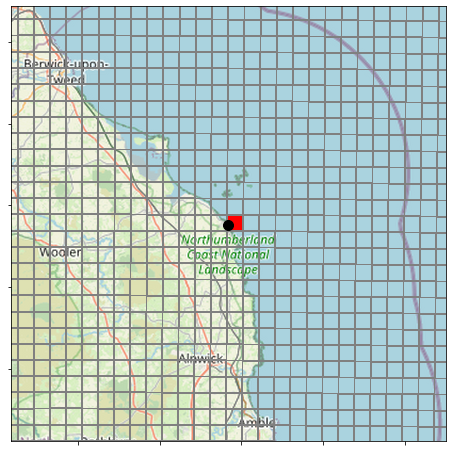

All files already exist for gauge 6 and year 2001
Using cached data for year 2002
befire
48.3203125
aftir
Finding the AMAX for 0.5hr events for gauge 6 in year 2002
Finding the AMAX for 1hr events for gauge 6 in year 2002
Finding the AMAX for 2hr events for gauge 6 in year 2002
Finding the AMAX for 3hr events for gauge 6 in year 2002
Finding the AMAX for 6hr events for gauge 6 in year 2002
Finding the AMAX for 12hr events for gauge 6 in year 2002
2 events
Finding the AMAX for 24hr events for gauge 6 in year 2002
2 events
Loading data for year 2003
befire
20.902721405029297
aftir
Finding the AMAX for 0.5hr events for gauge 6 in year 2003
Finding the AMAX for 1hr events for gauge 6 in year 2003
Finding the AMAX for 2hr events for gauge 6 in year 2003
Finding the AMAX for 3hr events for gauge 6 in year 2003
Finding the AMAX for 6hr events for gauge 6 in year 2003
Finding the AMAX for 12hr events for gauge 6 in year 2003
Finding the AMAX for 24hr events for gauge 6 in year 2003
Loading dat

In [ ]:
import os
import glob
import iris
import pandas as pd

# Read in a sample cube for finding the location of gauge in grid
sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/bc005/1980_2001/bng_bc005a.pr200508*')[0][1,:,:]

def load_and_cache_cube(year, cache, filenames_pattern, constraint = None):
    if year in cache:
        print(f"Using cached data for year {year}")
        return cache[year]

    print(f"Loading data for year {year}")
    filenames = [filename for filename in glob.glob(filenames_pattern) if f'pr{year}' in filename]

    if not filenames:
        raise FileNotFoundError(f"No files found for the year {year} with pattern {filenames_pattern}")
    
    if constraint not None:
        cubes = iris.load(filenames, constraint)
    else:
        cubes = iris.load(filenames)
        
    cube = cubes.concatenate_cube()
    cache[year] = cube

    return cube

# Initialize an empty cache
jja_cube_cache = {}
cube_cache = {}

# Loop through gauges
for gauge_num in range(6, 10):
    print(f"Processing gauge {gauge_num}")

    # Check if the directory for Option 2 exists for this gauge
    option2_dir = f"../../ProcessedData/IndependentEvents/UKCP18_30mins/bc005/{gauge_num}/Option2"
    if not os.path.isdir(option2_dir):
        os.makedirs(option2_dir)

    # Find the Tb0 and index of this gauge
    Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(gauge_num, sample_cube)

    for yr in range(2001, 2020):
        # Check if any files are missing for this year
        if not any(os.path.exists(f"{option2_dir}/{duration}hrs_{yr}_v2_part0.csv") for duration in [0.5, 1, 2, 3, 6, 12, 24]):
            
            # Load data for this year
            general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/bc005/1980_2001/bng_bc005a.pr{yr}*'
            cube = load_and_cache_cube(yr, cube_cache, general_filename)
            jja_cube = load_and_cache_cube(yr, jja_cube_cache, general_filename)

            # Extract data for the specified indices
            data = cube[:, idx_2d[0], idx_2d[1]].data

            # Create a DataFrame from the data
            df = pd.DataFrame(data, columns=['precipitation (mm)'])
            df = pd.DataFrame(data, columns=['precipitation (mm/hr)'])
            df['times'] = cube[:,idx_2d[0],idx_2d[1]].coord('time').units.num2date(cube.coord('time').points)
            # New precipitation accumulation column
            df['precipitation (mm)'] = df['precipitation (mm/hr)']/2   

            # Loop through duration
            for duration in [0.5, 1, 2, 3, 6, 12, 24]:
                # Check if this duration is missing
                if not os.path.exists(f"{option2_dir}/{duration}hrs_{yr}_v2_part0.csv"):
                    print(f"Finding the AMAX for {duration}hr events for gauge {gauge_num} in year {yr}")

                    # Find event (might be more than one)
                    events_v2 = find_amax_indy_events_v2(df, duration=duration, Tb0=Tb0)

                    # For each of the events
                    for num, event in enumerate(events_v2):
                        if len(event) > 1:
                            event.to_csv(f"{option2_dir}/{duration}hrs_{yr}_v2_part{num}.csv")
        else:
            print(f"All files already exist for gauge {gauge_num} and year {yr}")
